In [1]:
import os
import warnings
import shap

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold


# Change working directory
os.chdir('../..')

from utils.config import load_config, apply_plotting_settings, set_seed
from src.task_1.batch_corrector import BatchCorrector
from src.task_1.processing_helpers import *
from src.task_1.processing_pipeline import *
from src.task_1.model_training import ModelTrainer, ShapWrapper, plot_feature_importance

# Suppress warnings
warnings.filterwarnings("ignore")


c:\Users\Philippine\Documents\Job search\Isospec\isospec-internship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_config('config.json')
RNG = np.random.RandomState(config['seed'])

# Data processing

## Define data pipeline

In [3]:

paths = [os.path.join(config['data']['data_dir_1'], f) for f in ['internship_data_matrix.csv', 'internship_acquisition_list.csv']]

data_loader = PipelineStep(name='Data Loader', func=load_data,\
                        paths=paths, merge_on='sample')

batch_corrector = BatchCorrector()
batch_corrector.min_detection_rate = 0.7
batch_corrector.frac_loess = 0.36
batch_corrector.sample_classes = ['Healthy control', 'Cancer', 'Benign disease']

data_filter = PipelineStep(name='Filter batch & classes',\
                        func=filter_data, types = {'class': ['Healthy control', 'Cancer', 'Benign disease', 'QC'], 'batch': [1]})
final_filter = PipelineStep(name='Filter classes',
                         func=filter_data, types = {'class': ['Healthy control', 'Cancer', 'Benign disease']})

visualizer = PipelineStep(name='PCA projection',
                          func = pca, standardize=True)
QC_filter = PipelineStep(name='QC filter',\
                            func=filter_features_variability, verbose=True)
DRatio_filter = PipelineStep(name='D-ratio filter',
                             func=filter_features_dratio, sample_classes = ['Healthy control', 'Cancer', 'Benign disease'], verbose=True)
Detection_filter = PipelineStep(name='Feature detection filter',
                                func=filter_features_detection)
scaler = PipelineStep(name='StandardScaler',
                      func=normalize)
spliter = PipelineStep(name='Train-Test split',
                     func=split_train_test, seed = config['seed'])

In [4]:
pipeline = Pipeline()
pipeline.add([data_loader, data_filter, Detection_filter, visualizer, batch_corrector, visualizer, QC_filter, DRatio_filter, scaler, final_filter, spliter])

## Process data

After processing, we can observe how data cluster on the PCA projection plot. Namely, after intra-batch correction, QC samples cluster together.

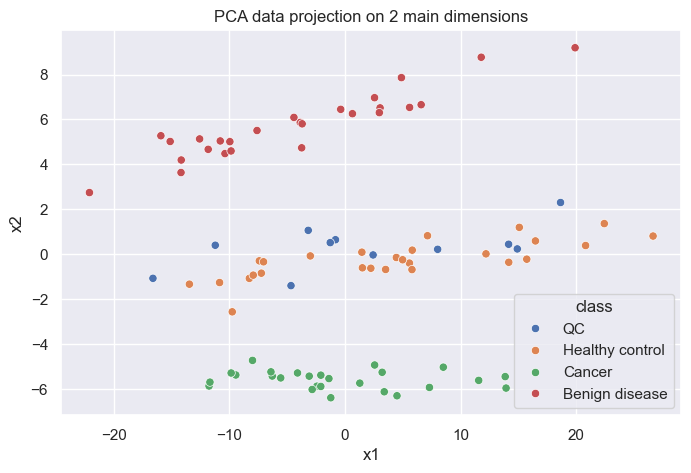

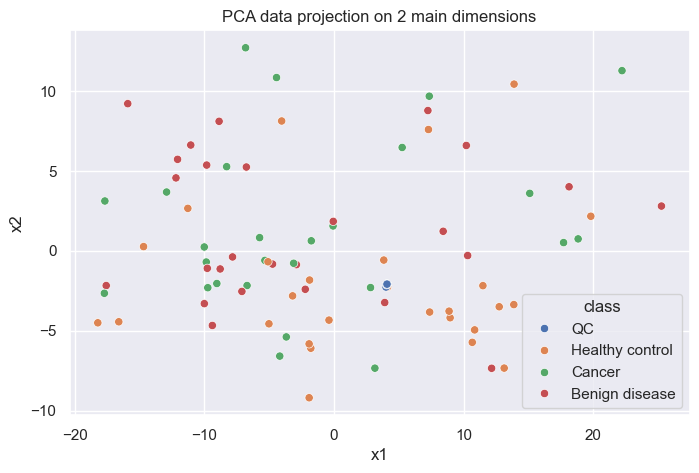

Running QC filter on data
Removing 2 features              with high variability :
['FT-145', 'FT-181']
Running D-ratio filter on data
Removing 0 features               with low biological information :
[]


In [5]:
x_tr, x_test, y_tr, y_test, class_map, features = pipeline.run()

In [6]:
features

['FT-000',
 'FT-001',
 'FT-002',
 'FT-003',
 'FT-004',
 'FT-005',
 'FT-006',
 'FT-007',
 'FT-008',
 'FT-009',
 'FT-010',
 'FT-011',
 'FT-012',
 'FT-014',
 'FT-015',
 'FT-016',
 'FT-017',
 'FT-018',
 'FT-019',
 'FT-020',
 'FT-021',
 'FT-022',
 'FT-023',
 'FT-024',
 'FT-025',
 'FT-026',
 'FT-027',
 'FT-029',
 'FT-030',
 'FT-031',
 'FT-032',
 'FT-033',
 'FT-034',
 'FT-035',
 'FT-036',
 'FT-037',
 'FT-039',
 'FT-040',
 'FT-041',
 'FT-042',
 'FT-043',
 'FT-044',
 'FT-045',
 'FT-046',
 'FT-048',
 'FT-049',
 'FT-050',
 'FT-052',
 'FT-053',
 'FT-054',
 'FT-055',
 'FT-056',
 'FT-057',
 'FT-058',
 'FT-059',
 'FT-061',
 'FT-062',
 'FT-063',
 'FT-064',
 'FT-066',
 'FT-067',
 'FT-069',
 'FT-070',
 'FT-073',
 'FT-074',
 'FT-075',
 'FT-076',
 'FT-077',
 'FT-078',
 'FT-080',
 'FT-081',
 'FT-082',
 'FT-083',
 'FT-084',
 'FT-085',
 'FT-087',
 'FT-088',
 'FT-089',
 'FT-090',
 'FT-092',
 'FT-093',
 'FT-094',
 'FT-095',
 'FT-096',
 'FT-097',
 'FT-098',
 'FT-099',
 'FT-100',
 'FT-101',
 'FT-102',
 'FT-103',

# Data classification

## Random Forest simple classifier

Best parameters found: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 25}
Model scoring: 0.9375


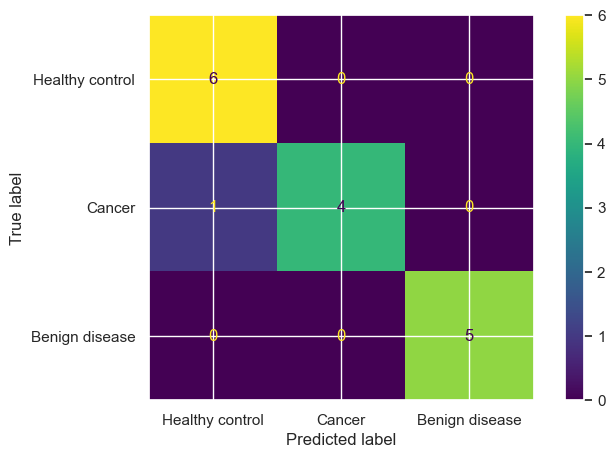

In [7]:
classifier = RandomForestClassifier(random_state=RNG)

param_distrib = config['models']['random_forest']['cv']

# Train model
trainer = ModelTrainer(classifier, param_grid=param_distrib, rng=RNG)
trainer.cv = 3
trainer.tune_model(x_tr, y_tr, score='balanced_accuracy')
trainer.train_model(x_tr, y_tr)

# Evaluate model
trainer.evaluate_model(x_test, y_test, metrics=accuracy_score)
y_pred = trainer.best_model.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[v for _, v in class_map.items()])
disp.plot()




# Best features identification

Walk through feature relevance for model classification. Namely, identify which feature contributes the most to the classifier prediction, and give precious insights for biomarker discovery. 

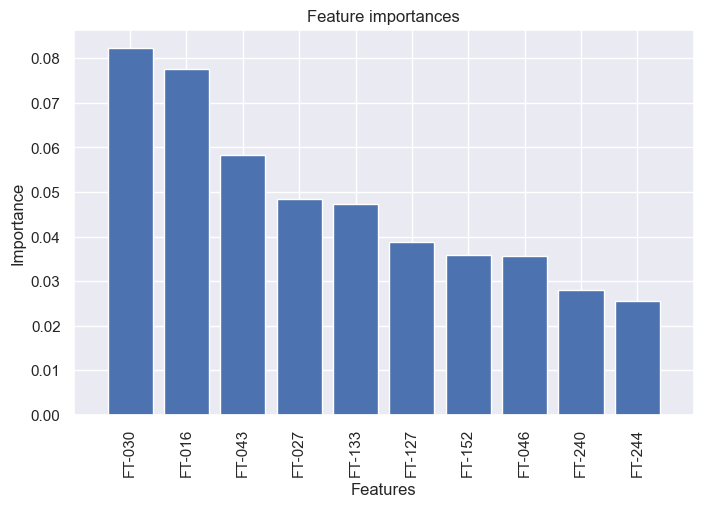

In [8]:
top_feats = plot_feature_importance(trainer.best_model, features)

Ranking features by their gini index, we end up with the following top 10 discriminative features.

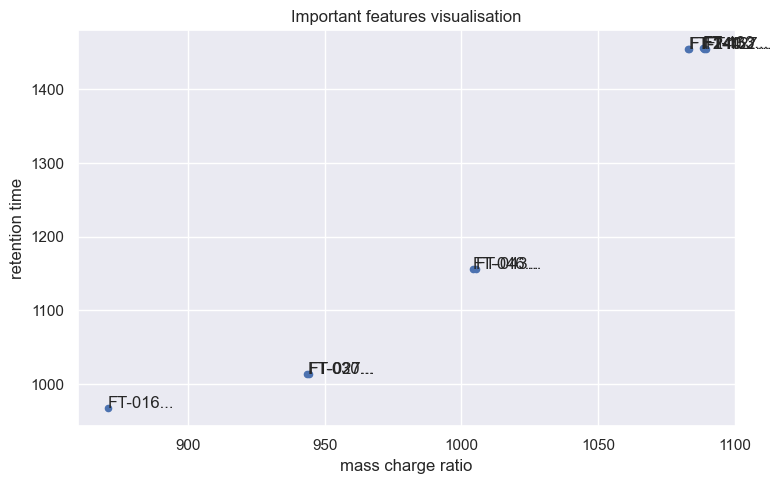

In [9]:
df_feature_meta = pd.read_csv(os.path.join('data/input', 'internship_feature_metadata.csv'))

top_feats_meta = df_feature_meta[df_feature_meta['feature'].isin(top_feats)][['mz', 'rt', 'feature']]
fig = top_feats_meta.plot.scatter(x='mz', y='rt')

for i, point in top_feats_meta.set_index('feature').iterrows():
    fig.text(point[0]+.03, point[1], str(i)[:15] + '...')

plt.xlabel('mass charge ratio')
plt.ylabel('retention time')
plt.title('Important features visualisation')
plt.tight_layout()

Plotting features based on their mass charge ratio and retention time characteristics enable the detection of similar features. Namely, we can identify 7 feature clusters.

## Class specific feature identification

SHAP is a method based on game theory to explain a given ML model individual predictions. 
Roughly, it predicts each feature contribution to the prediction. For instance, we train a model to predict housing prices for a given house based on several features such as the number of rooms. We can compute for this given feature, namely number of rooms, the contribution to the overall housing price prediction.

Here we compute the top features contributions to the classifier predicting either Cancer, Benign disease (_benign disease_) and Healthy control.


In [10]:
df_tr = pd.DataFrame(x_tr, columns=features) # background
df_te = pd.DataFrame(x_test, columns=features)

shap_explainer = ShapWrapper(trainer.best_model, background=df_tr,\
                              classes = {v : k for k, v in class_map.items()})

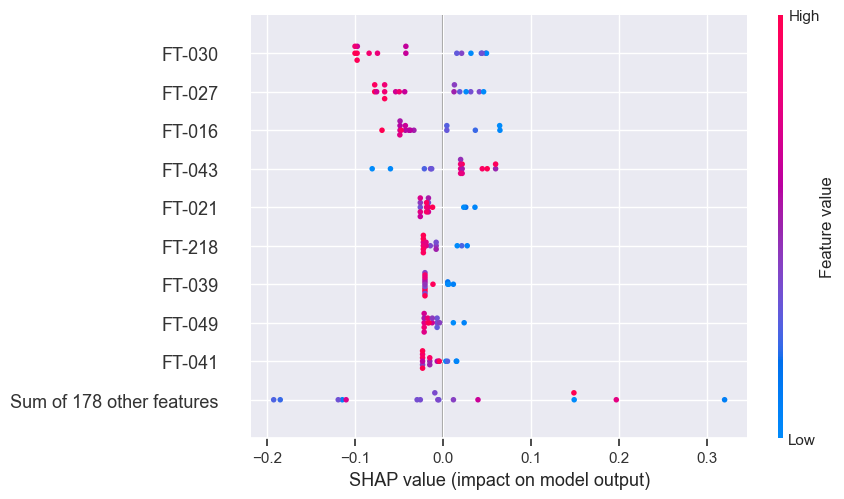

In [12]:
shap_explainer.plot_summary(df_te, cl='Cancer')

According to the shap features plot, a high relative abundance of feature 43 seems to push the model towards predicting lung cancer. This feature might thus be a potential biomarker.

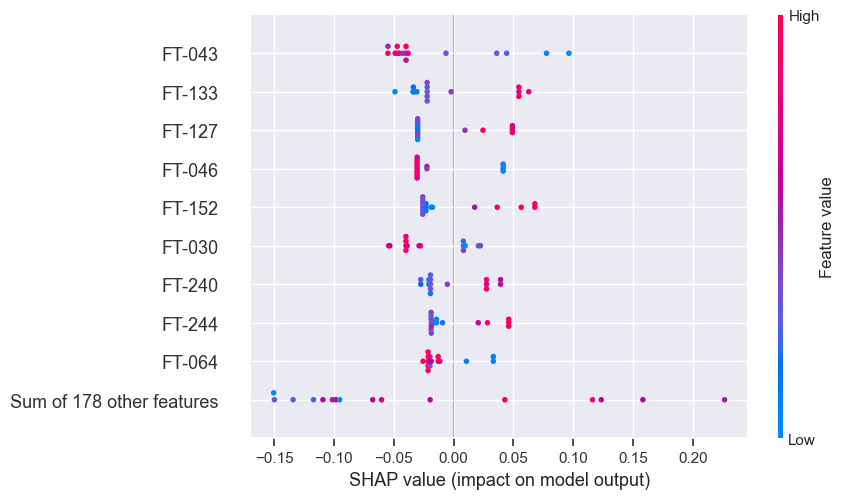

In [13]:
shap_explainer.plot_summary(df_te, cl='Benign disease')

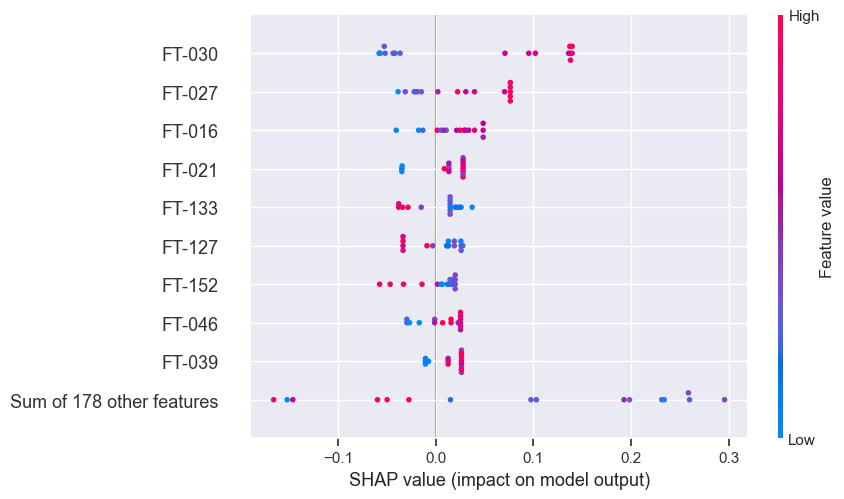

In [14]:
shap_explainer.plot_summary(df_te, cl='Healthy control')